## Generate of spectra in tensorflow for the YOLO model

In [1]:
import math
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

Ranges of parameters in units and constants used in experiment.

In [2]:
sp_min, sp_max = -10., 10.
fr_min, fr_max = 0., 256.
dc_min, dc_max = 0.1, 10.
am_min, am_max = 0.1, 5.

series = 20
dwmin, dwmax = -10., 10.

Number of pixels and cells along the speed and frequency dimension.

In [3]:
sp_pixels, fr_pixels = 256, 256
sp_cells, fr_cells = 16, 16

Offsets of cells relative to the entire grid in range from 0 to number of cells.

In [4]:
fr_offsets, sp_offsets = tf.meshgrid(tf.range(fr_cells, dtype = tf.float32),
                                     tf.range(sp_cells, dtype = tf.float32))

Random number of peaks from 1 to 9.

In [5]:
peaks = tf.random.uniform([], 1, 10, dtype = tf.int32)

Random objectness labels as 1. or 0. if a cell contains a peak or not.

In [6]:
ob_labels = tf.concat([tf.ones([peaks]), tf.zeros([sp_cells * fr_cells - peaks])], -1)
ob_labels = tf.random.shuffle(ob_labels)
ob_labels = tf.reshape(ob_labels, [sp_cells, fr_cells])

Random peak parameters relative to each cell in range from 0 to 1.

In [7]:
sp_shifts = tf.random.uniform([sp_cells, fr_cells])
fr_shifts = tf.random.uniform([sp_cells, fr_cells])
dc_shifts = tf.random.uniform([sp_cells, fr_cells])
am_shifts = tf.random.uniform([sp_cells, fr_cells])

Peak parameters relative to the entire grid in range from 0 to 1.

In [8]:
sp_units = (sp_offsets + sp_shifts) / sp_cells
fr_units = (fr_offsets + fr_shifts) / fr_cells
dc_units = dc_shifts
am_units = am_shifts

Peak parameters in units used in experiment.

In [9]:
sp_values = sp_units * (sp_max - sp_min) + sp_min
fr_values = fr_units * (fr_max - fr_min) + fr_min
dc_values = dc_units * (dc_max - dc_min) + dc_min
am_values = am_units * (am_max - am_min) + am_min

Auxiliary arrays for generating spectrum in tensorflow.

In [10]:
t = tf.complex(tf.range(2 * fr_pixels, dtype = tf.float32) / fr_pixels / 2., 0.)
a = tf.range(series, dtype = tf.float32)
b = 2. * math.pi * \
    tf.complex(0., tf.range(dwmin, dwmax, (dwmax - dwmin) / sp_pixels, dtype = tf.float32))[:, None] * t

Spectrum generated in tensorflow.

In [11]:
f = a[:, None, None] * sp_values + fr_values + fr_pixels / 2.
fid = tf.complex(ob_labels * am_values, 0.) * \
      tf.exp(2. * math.pi * t[:, None, None, None] * (tf.complex(-dc_values, f))) * \
      tf.cast(tf.logical_and(0.8 * fr_pixels / 2. <= f, f <= 2. * fr_pixels - 0.8 * fr_pixels / 2.), tf.complex64)
fid = tf.reduce_sum(fid, [2, 3])
fid = tf.concat([fid[: 1] / 2., fid[1:]], 0)
p = tf.exp(-b[:, :, None] * tf.complex(a, 0.)) * fid
spectrum_tf = tf.math.real(tf.signal.fft(tf.reduce_sum(p, 2)))[:, fr_pixels // 2 : 2 * fr_pixels - fr_pixels // 2]

Ploting the tensorflow spectrum.

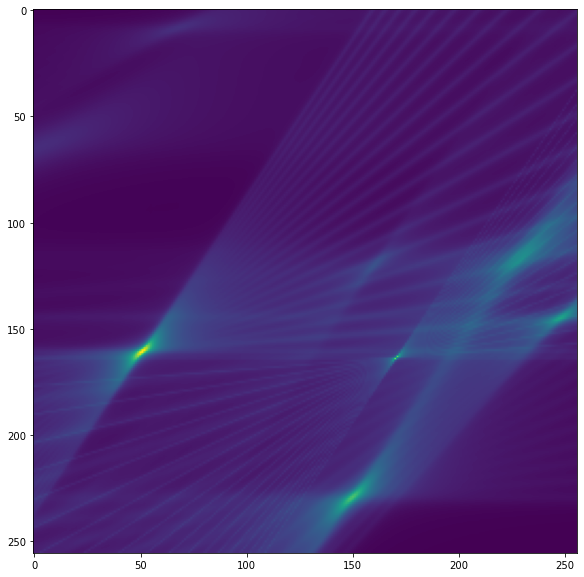

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(tf.transpose(spectrum_tf))
plt.show()